# K-Means for Hearing Threshold Data Clustering - Re-weighting by Age

`Each participant's both ears are treated as if they were two participants.`

In [21]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score

import seaborn as sns
import numpy as np

In [22]:
# Load the data
file_path = "../../data/nhanes_1520_age.csv"
data = pd.read_csv(file_path)
data.set_index('SEQN', inplace=True)
print(data.shape)
data.head()

(9729, 15)


,AUXU500R,AUXU1K1R,AUXU2KR,AUXU3KR,AUXU4KR,AUXU6KR,AUXU8KR,AUXU500L,AUXU1K1L,AUXU2KL,AUXU3KL,AUXU4KL,AUXU6KL,AUXU8KL,RIDAGEYR
SEQN,,,,,,,,,,,,,,,
83732,10.0,5.0,5.0,20.0,30.0,25.0,50.0,5.0,5.0,5.0,35.0,50.0,50.0,55.0,62
83733,10.0,15.0,40.0,55.0,60.0,55.0,65.0,5.0,20.0,50.0,55.0,60.0,55.0,60.0,53
83735,25.0,25.0,30.0,20.0,40.0,40.0,55.0,15.0,25.0,30.0,30.0,45.0,60.0,50.0,56
83736,10.0,10.0,10.0,15.0,10.0,15.0,20.0,15.0,10.0,15.0,25.0,15.0,25.0,20.0,42
83741,5.0,0.0,5.0,5.0,5.0,20.0,15.0,0.0,-5.0,0.0,5.0,-5.0,10.0,10.0,22


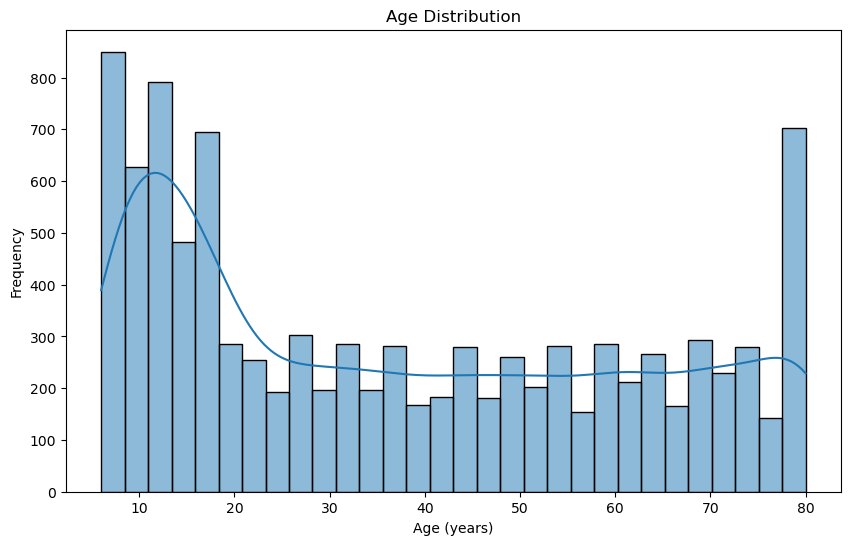

In [23]:
# Check the age distribution in the column 'RIDAGEYR'
plt.figure(figsize=(10, 6))
sns.histplot(data['RIDAGEYR'], bins=30, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age (years)')
plt.ylabel('Frequency')
plt.show()

In [24]:
# Select the columns for right ear measurements

right_ear_columns = ['AUXU500R', 'AUXU1K1R', 'AUXU2KR', 'AUXU3KR', 'AUXU4KR', 'AUXU6KR', 'AUXU8KR', 'RIDAGEYR']
right_ear_data = data[right_ear_columns]
right_ear_data.columns = ['500 Hz', '1 kHz', '2 kHz', '3 kHz', '4 kHz', '6 kHz', '8 kHz', 'Age']

# Select the columns for left ear measurements

left_ear_columns = ['AUXU500L', 'AUXU1K1L', 'AUXU2KL', 'AUXU3KL', 'AUXU4KL', 'AUXU6KL', 'AUXU8KL', 'RIDAGEYR']
left_ear_data = data[left_ear_columns]
left_ear_data.columns = ['500 Hz', '1 kHz', '2 kHz', '3 kHz', '4 kHz', '6 kHz', '8 kHz', 'Age']

# Concatenate the right and left ear data

ear_data = pd.concat([right_ear_data, left_ear_data], axis=0)

ear_data

,500 Hz,1 kHz,2 kHz,3 kHz,4 kHz,6 kHz,8 kHz,Age
SEQN,,,,,,,,
83732,10.0,5.0,5.0,20.0,30.0,25.0,50.0,62
83733,10.0,15.0,40.0,55.0,60.0,55.0,65.0,53
83735,25.0,25.0,30.0,20.0,40.0,40.0,55.0,56
83736,10.0,10.0,10.0,15.0,10.0,15.0,20.0,42
83741,5.0,0.0,5.0,5.0,5.0,20.0,15.0,22
...,...,...,...,...,...,...,...,...
124797,888.0,0.0,-5.0,888.0,5.0,888.0,10.0,9
124799,20.0,40.0,45.0,45.0,60.0,85.0,666.0,80
124811,35.0,30.0,15.0,30.0,25.0,55.0,60.0,76


In [25]:
# Process missing values
cleaned_ear_data = ear_data.replace({888: np.nan, 666: np.nan, '.': np.nan}, inplace=False)
cleaned_ear_data = cleaned_ear_data.dropna(inplace=False)

# Extract the age column

age_data = cleaned_ear_data['Age']

# Turn age data into sample weights

age_weights = age_data / age_data.sum()
age_quad_weights = age_data ** 2 / (age_data ** 2).sum()

# Drop the age column from the cleaned_ear_data data

cleaned_ear_data.drop('Age', axis=1, inplace=True)

cleaned_ear_data

,500 Hz,1 kHz,2 kHz,3 kHz,4 kHz,6 kHz,8 kHz
SEQN,,,,,,,
83732,10.0,5.0,5.0,20.0,30.0,25.0,50.0
83733,10.0,15.0,40.0,55.0,60.0,55.0,65.0
83735,25.0,25.0,30.0,20.0,40.0,40.0,55.0
83736,10.0,10.0,10.0,15.0,10.0,15.0,20.0
83741,5.0,0.0,5.0,5.0,5.0,20.0,15.0
...,...,...,...,...,...,...,...
124784,45.0,50.0,50.0,50.0,50.0,45.0,80.0
124786,0.0,10.0,10.0,5.0,0.0,15.0,0.0
124787,20.0,10.0,5.0,5.0,5.0,10.0,5.0


In [26]:
# Standardize the data
standard_scaler = StandardScaler()
standard_scaled_data = standard_scaler.fit_transform(cleaned_ear_data)

# Min-max scaling
minmax_scaler = MinMaxScaler()
minmax_scaled_data = minmax_scaler.fit_transform(cleaned_ear_data)

# Robust scaling
## Note: Robust scaling is computed as (X - median) / IQR
robust_scaler = RobustScaler()
robust_scaled_data = robust_scaler.fit_transform(cleaned_ear_data)

# Quantile transformation
quantile_transformer = QuantileTransformer(output_distribution='normal')
quantile_transformed_data = quantile_transformer.fit_transform(cleaned_ear_data)

# K-Means with raw data

KMeans with 2 clusters
Silhouette Score: 0.595
Davies Bouldin Score: 0.676
Calinski Harabasz Score: 24777.968
--------------------------------------------------
KMeans with 3 clusters
Silhouette Score: 0.464
Davies Bouldin Score: 0.961
Calinski Harabasz Score: 20002.563
--------------------------------------------------
KMeans with 4 clusters
Silhouette Score: 0.362
Davies Bouldin Score: 1.141
Calinski Harabasz Score: 16862.402
--------------------------------------------------


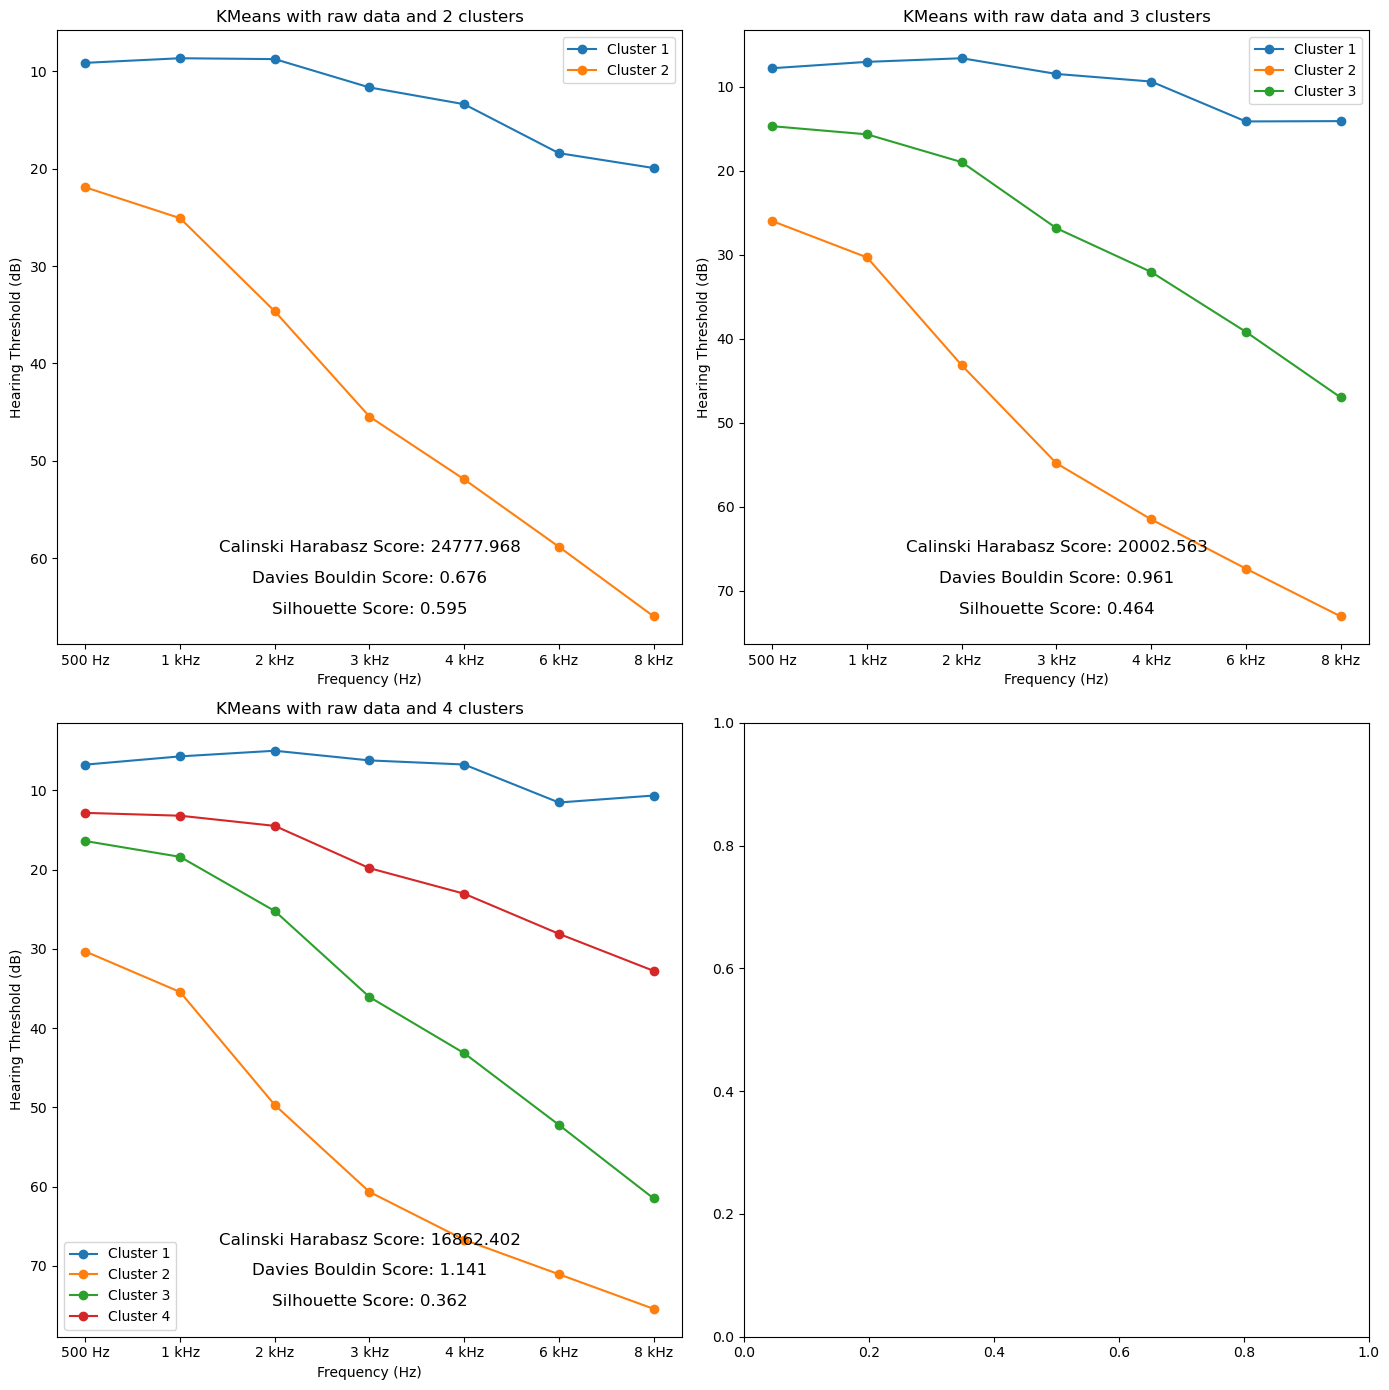

In [27]:
# Fit the K-Means algorithm with n clusters = 2, 3, 4

fig, ax = plt.subplots(2, 2, figsize=(14, 14))

for i in range(2, 5):
    # Initialize the KMeans object
    kmeans = KMeans(n_clusters=i, random_state=42, n_init='auto')
    kmeans.fit(cleaned_ear_data, sample_weight = age_weights)

    # Extract the centroids
    centroids = kmeans.cluster_centers_
    centroids_df = pd.DataFrame(centroids, columns=cleaned_ear_data.columns)

    # Plot the line plot
    row = (i - 2) // 2
    col = (i - 2) % 2
    for cluster_id in range(i):
        ax[row, col].plot(
            centroids_df.columns, 
            centroids_df.iloc[cluster_id], 
            marker='o', 
            label=f'Cluster {cluster_id + 1}'
        )
    ax[row, col].set_title(f'KMeans with raw data and {i} clusters')
    ax[row, col].set_xlabel('Frequency (Hz)')
    ax[row, col].set_ylabel('Hearing Threshold (dB)')
    ax[row, col].invert_yaxis()
    ax[row, col].legend()

    # Annotate the Silhouette, Davies Bouldin, and Calinski Harabasz scores
    silhouette = silhouette_score(cleaned_ear_data, kmeans.labels_)
    davies_bouldin = davies_bouldin_score(cleaned_ear_data, kmeans.labels_)
    calinski_harabasz = calinski_harabasz_score(cleaned_ear_data, kmeans.labels_)

    ax[row, col].annotate(f'Silhouette Score: {silhouette:.3f}', 
                          xy=(0.5, 0.05), xycoords='axes fraction', ha='center', fontsize=12)
    ax[row, col].annotate(f'Davies Bouldin Score: {davies_bouldin:.3f}',
                            xy=(0.5, 0.10), xycoords='axes fraction', ha='center', fontsize=12)
    ax[row, col].annotate(f'Calinski Harabasz Score: {calinski_harabasz:.3f}',
                            xy=(0.5, 0.15), xycoords='axes fraction', ha='center', fontsize=12)
    
    # Print out the Silhouette, Davies Bouldin, and Calinski Harabasz scores
    print(f'KMeans with {i} clusters')
    print(f'Silhouette Score: {silhouette:.3f}')
    print(f'Davies Bouldin Score: {davies_bouldin:.3f}')
    print(f'Calinski Harabasz Score: {calinski_harabasz:.3f}')
    print('-' * 50)

plt.tight_layout()
plt.show()

# K-Means with centered data

KMeans with 2 clusters
Silhouette Score: 0.588
Davies Bouldin Score: 0.676
Calinski Harabasz Score: 22675.103
--------------------------------------------------
KMeans with 3 clusters
Silhouette Score: 0.485
Davies Bouldin Score: 1.006
Calinski Harabasz Score: 17854.962
--------------------------------------------------
KMeans with 4 clusters
Silhouette Score: 0.389
Davies Bouldin Score: 1.220
Calinski Harabasz Score: 14913.140
--------------------------------------------------


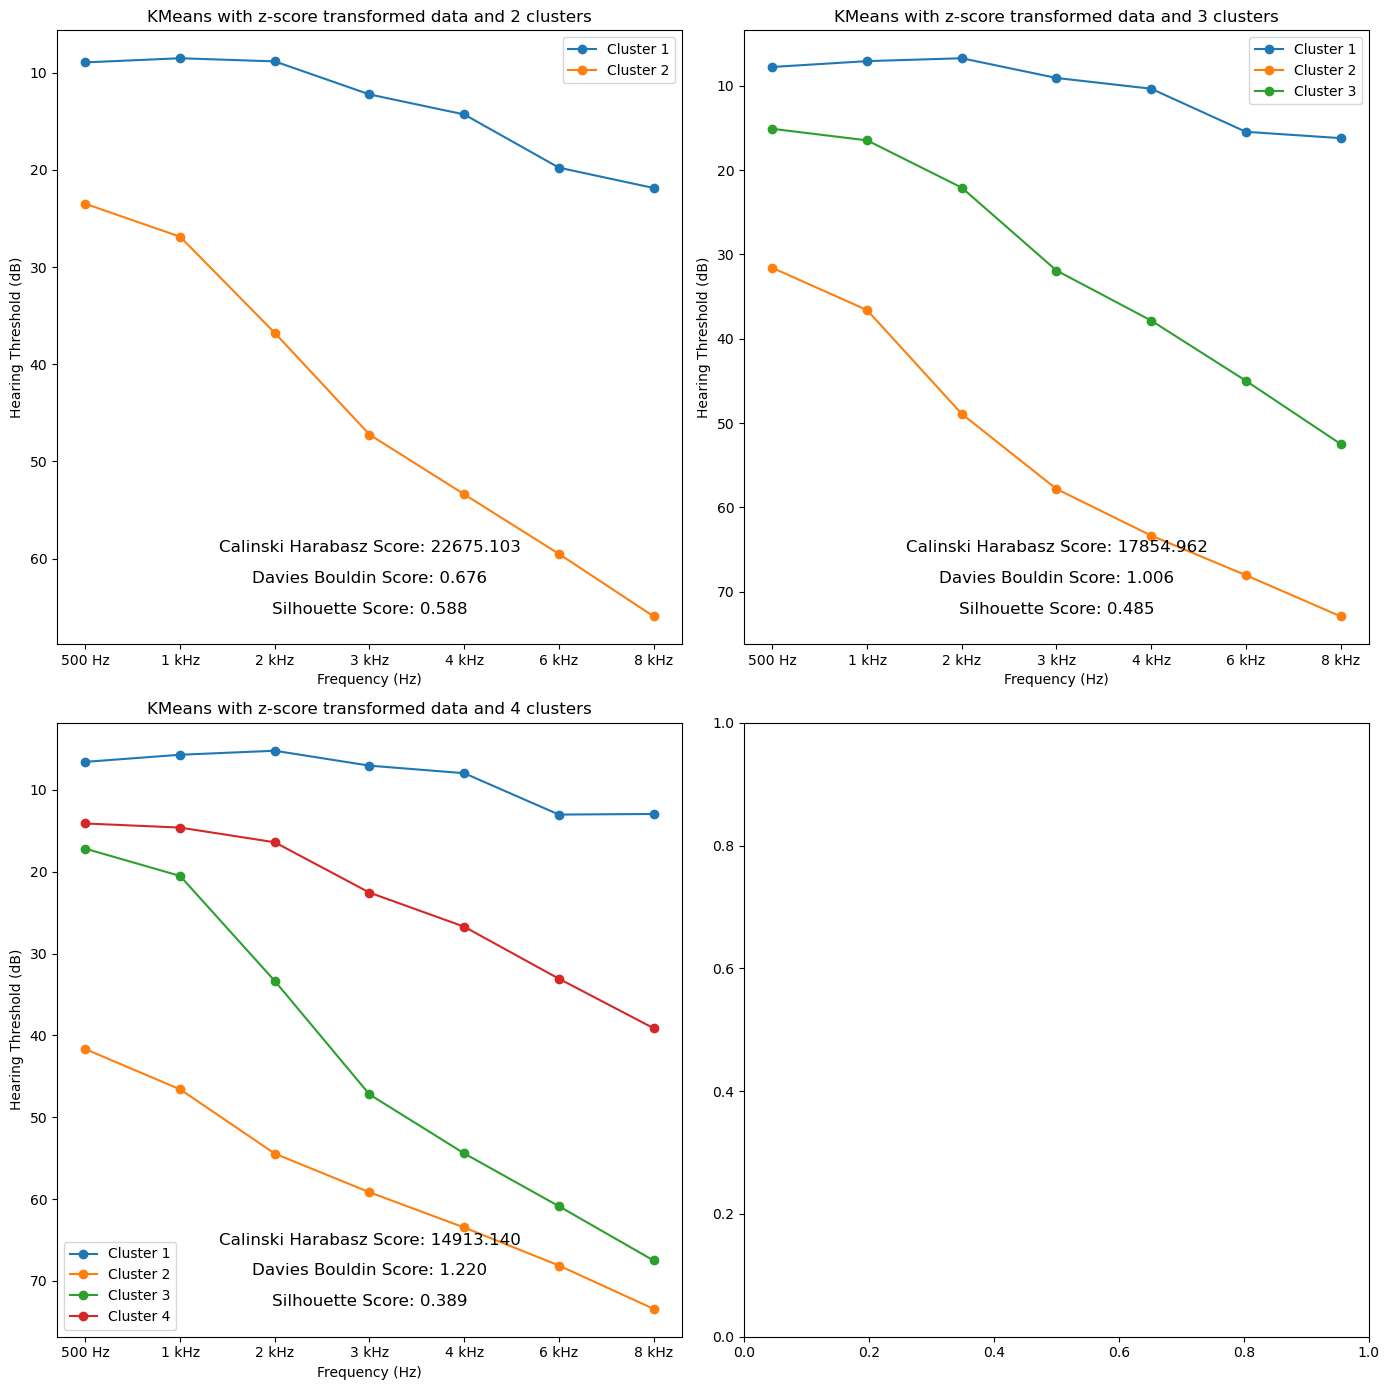

In [14]:
# Fit the K-Means algorithm with n clusters = 2, 3, 4

fig, ax = plt.subplots(2, 2, figsize=(14, 14))

for i in range(2, 5):
    # Initialize the KMeans object
    kmeans = KMeans(n_clusters=i, random_state=42, n_init='auto')
    kmeans.fit(standard_scaled_data, sample_weight = age_weights)

    # Extract the centroids
    centroids = standard_scaler.inverse_transform(kmeans.cluster_centers_)
    centroids_df = pd.DataFrame(centroids, columns=cleaned_ear_data.columns)

    # Plot the line plot
    row = (i - 2) // 2
    col = (i - 2) % 2
    for cluster_id in range(i):
        ax[row, col].plot(
            centroids_df.columns, 
            centroids_df.iloc[cluster_id], 
            marker='o', 
            label=f'Cluster {cluster_id + 1}'
        )
    ax[row, col].set_title(f'KMeans with z-score transformed data and {i} clusters')
    ax[row, col].set_xlabel('Frequency (Hz)')
    ax[row, col].set_ylabel('Hearing Threshold (dB)')
    ax[row, col].invert_yaxis()
    ax[row, col].legend()

    # Annotate the Silhouette, Davies Bouldin, and Calinski Harabasz scores
    silhouette = silhouette_score(cleaned_ear_data, kmeans.labels_)
    davies_bouldin = davies_bouldin_score(cleaned_ear_data, kmeans.labels_)
    calinski_harabasz = calinski_harabasz_score(cleaned_ear_data, kmeans.labels_)

    ax[row, col].annotate(f'Silhouette Score: {silhouette:.3f}', 
                          xy=(0.5, 0.05), xycoords='axes fraction', ha='center', fontsize=12)
    ax[row, col].annotate(f'Davies Bouldin Score: {davies_bouldin:.3f}',
                            xy=(0.5, 0.10), xycoords='axes fraction', ha='center', fontsize=12)
    ax[row, col].annotate(f'Calinski Harabasz Score: {calinski_harabasz:.3f}',
                            xy=(0.5, 0.15), xycoords='axes fraction', ha='center', fontsize=12)
    
    # Print out the Silhouette, Davies Bouldin, and Calinski Harabasz scores
    print(f'KMeans with {i} clusters')
    print(f'Silhouette Score: {silhouette:.3f}')
    print(f'Davies Bouldin Score: {davies_bouldin:.3f}')
    print(f'Calinski Harabasz Score: {calinski_harabasz:.3f}')
    print('-' * 50)

plt.tight_layout()
plt.show()

## KMeans with min-max standardized data

KMeans with 2 clusters
Silhouette Score: 0.595
Davies Bouldin Score: 0.677
Calinski Harabasz Score: 24786.249
--------------------------------------------------
KMeans with 3 clusters
Silhouette Score: 0.466
Davies Bouldin Score: 0.961
Calinski Harabasz Score: 19919.134
--------------------------------------------------
KMeans with 4 clusters
Silhouette Score: 0.362
Davies Bouldin Score: 1.137
Calinski Harabasz Score: 16849.882
--------------------------------------------------


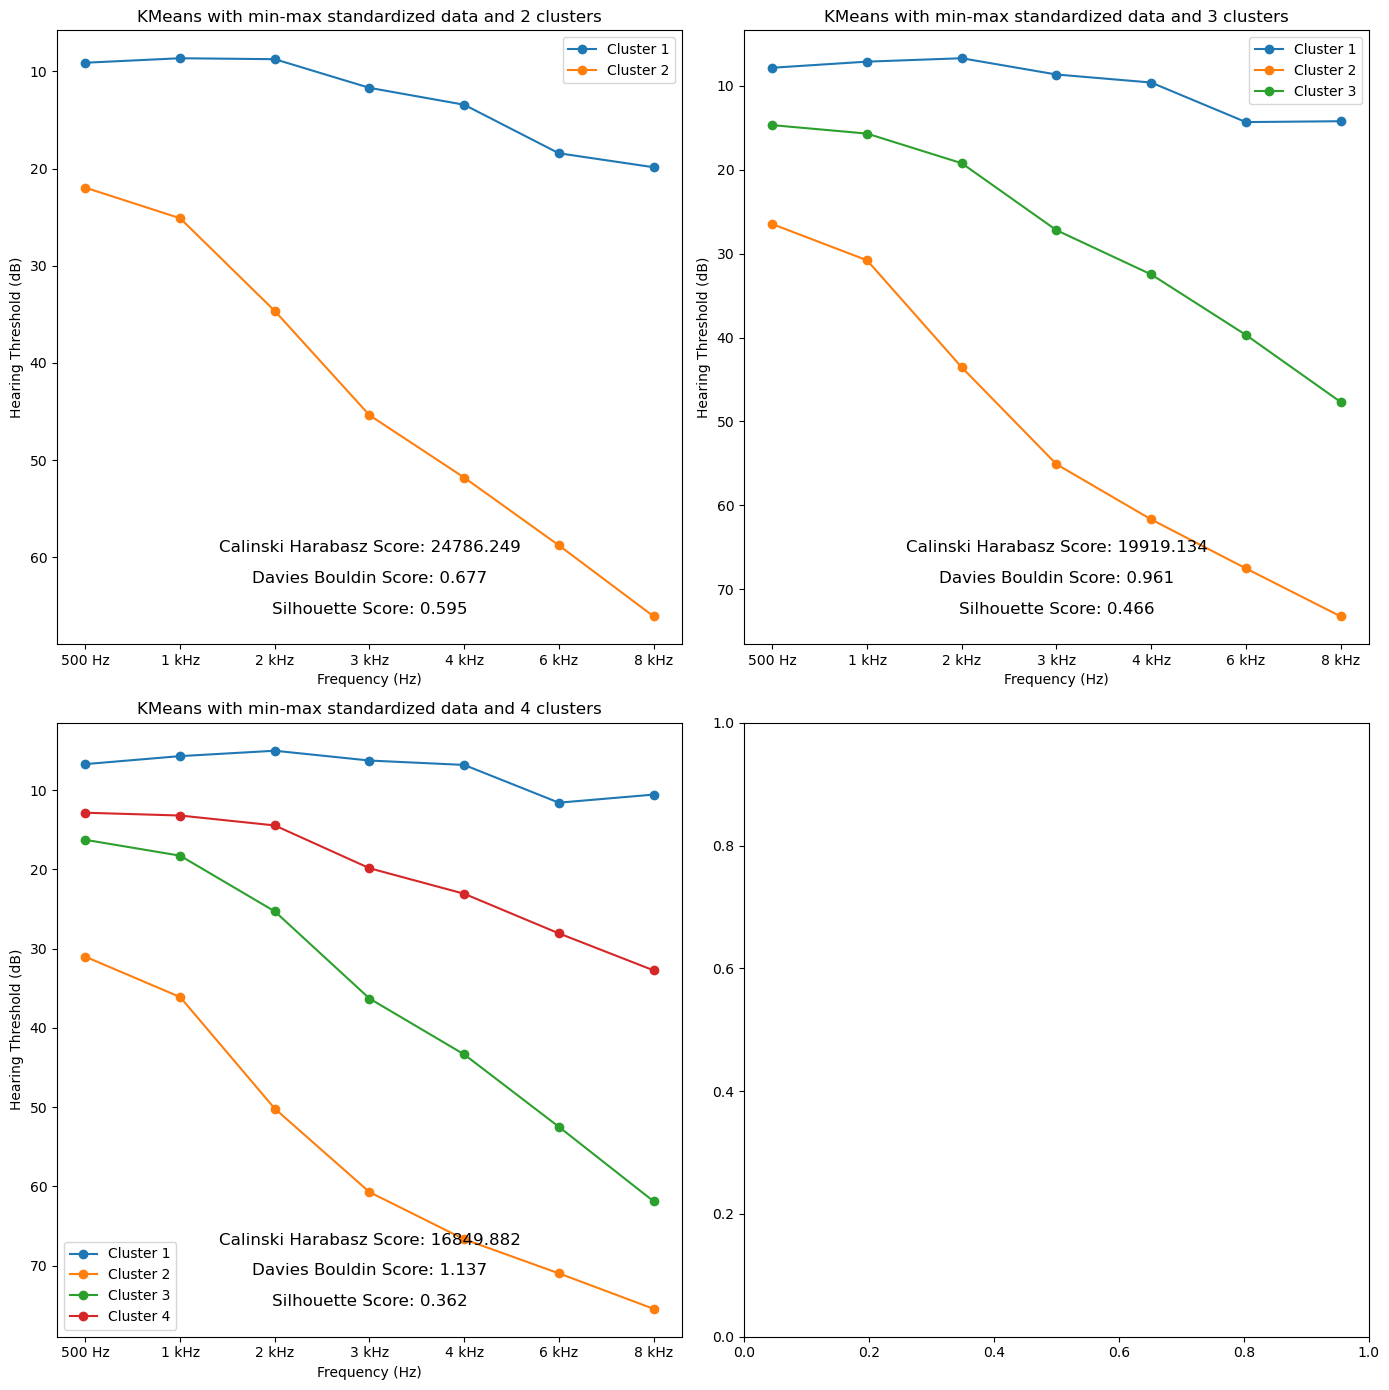

In [15]:
# K-Means with min-max standardized data

# Fit the K-Means algorithm with n clusters = 2, 3, 4

fig, ax = plt.subplots(2, 2, figsize=(14, 14))

for i in range(2, 5):
    # Initialize the KMeans object
    kmeans = KMeans(n_clusters=i, random_state=42, n_init='auto')
    kmeans.fit(minmax_scaled_data, sample_weight = age_weights)

    # Extract the centroids
    centroids = minmax_scaler.inverse_transform(kmeans.cluster_centers_)
    centroids_df = pd.DataFrame(centroids, columns=cleaned_ear_data.columns)

    # Plot the line plot
    row = (i - 2) // 2
    col = (i - 2) % 2
    for cluster_id in range(i):
        ax[row, col].plot(
            centroids_df.columns, 
            centroids_df.iloc[cluster_id], 
            marker='o', 
            label=f'Cluster {cluster_id + 1}'
        )
    ax[row, col].set_title(f'KMeans with min-max standardized data and {i} clusters')
    ax[row, col].set_xlabel('Frequency (Hz)')
    ax[row, col].set_ylabel('Hearing Threshold (dB)')
    ax[row, col].invert_yaxis()
    ax[row, col].legend()

    # Annotate the Silhouette, Davies Bouldin, and Calinski Harabasz scores
    silhouette = silhouette_score(cleaned_ear_data, kmeans.labels_)
    davies_bouldin = davies_bouldin_score(cleaned_ear_data, kmeans.labels_)
    calinski_harabasz = calinski_harabasz_score(cleaned_ear_data, kmeans.labels_)

    ax[row, col].annotate(f'Silhouette Score: {silhouette:.3f}', 
                          xy=(0.5, 0.05), xycoords='axes fraction', ha='center', fontsize=12)
    ax[row, col].annotate(f'Davies Bouldin Score: {davies_bouldin:.3f}',
                            xy=(0.5, 0.10), xycoords='axes fraction', ha='center', fontsize=12)
    ax[row, col].annotate(f'Calinski Harabasz Score: {calinski_harabasz:.3f}',
                            xy=(0.5, 0.15), xycoords='axes fraction', ha='center', fontsize=12)
    
    # Print out the Silhouette, Davies Bouldin, and Calinski Harabasz scores
    print(f'KMeans with {i} clusters')
    print(f'Silhouette Score: {silhouette:.3f}')
    print(f'Davies Bouldin Score: {davies_bouldin:.3f}')
    print(f'Calinski Harabasz Score: {calinski_harabasz:.3f}')
    print('-' * 50)

plt.tight_layout()
plt.show()

# K-Means with robust scaled data

KMeans with 2 clusters
Silhouette Score: 0.573
Davies Bouldin Score: 0.689
Calinski Harabasz Score: 19214.541
--------------------------------------------------
KMeans with 3 clusters
Silhouette Score: 0.472
Davies Bouldin Score: 1.050
Calinski Harabasz Score: 15992.993
--------------------------------------------------
KMeans with 4 clusters
Silhouette Score: 0.369
Davies Bouldin Score: 1.270
Calinski Harabasz Score: 12991.417
--------------------------------------------------


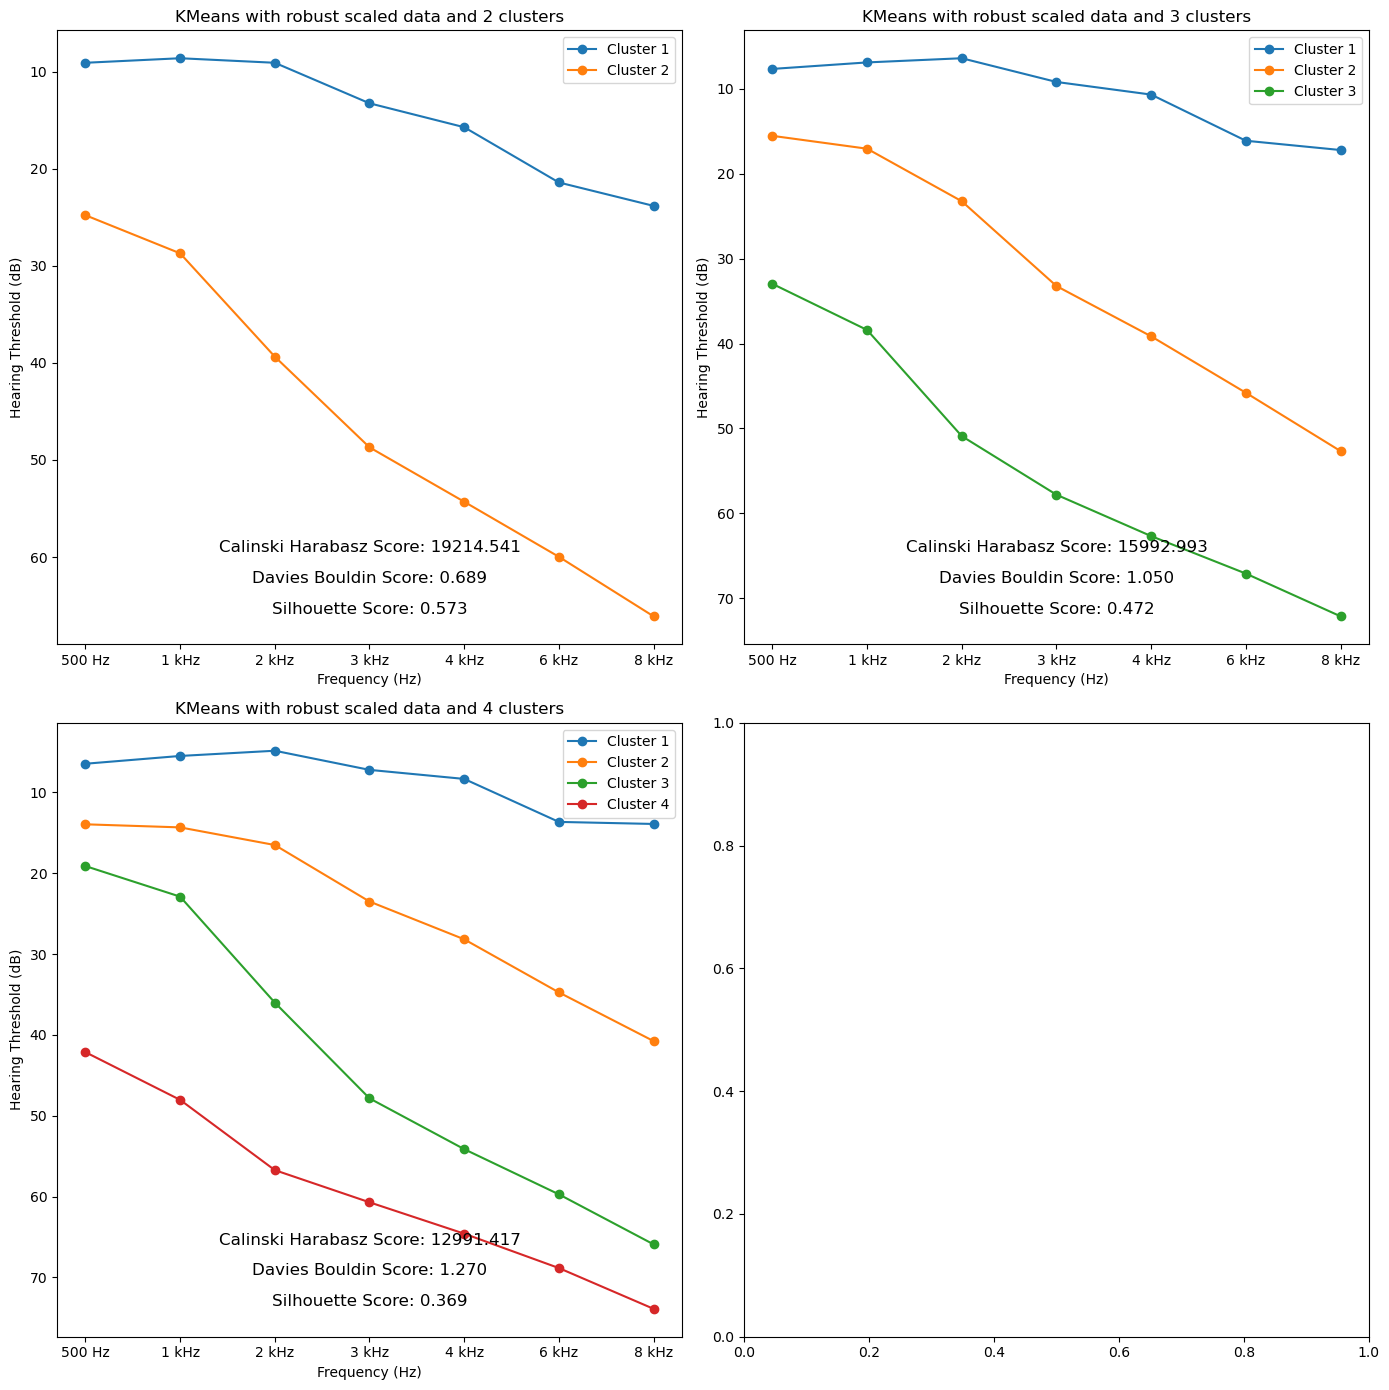

In [16]:
# K-Means with robust standardized data

# Fit the K-Means algorithm with n clusters = 2, 3, 4

fig, ax = plt.subplots(2, 2, figsize=(14, 14))

for i in range(2, 5):
    # Initialize the KMeans object
    kmeans = KMeans(n_clusters=i, random_state=42, n_init='auto')
    kmeans.fit(robust_scaled_data, sample_weight = age_weights)

    # Extract the centroids
    centroids = robust_scaler.inverse_transform(kmeans.cluster_centers_)
    centroids_df = pd.DataFrame(centroids, columns=cleaned_ear_data.columns)

    # Plot the line plot
    row = (i - 2) // 2
    col = (i - 2) % 2
    for cluster_id in range(i):
        ax[row, col].plot(
            centroids_df.columns, 
            centroids_df.iloc[cluster_id], 
            marker='o', 
            label=f'Cluster {cluster_id + 1}'
        )
    ax[row, col].set_title(f'KMeans with robust scaled data and {i} clusters')
    ax[row, col].set_xlabel('Frequency (Hz)')
    ax[row, col].set_ylabel('Hearing Threshold (dB)')
    ax[row, col].invert_yaxis()
    ax[row, col].legend()

    # Annotate the Silhouette, Davies Bouldin, and Calinski Harabasz scores
    silhouette = silhouette_score(cleaned_ear_data, kmeans.labels_)
    davies_bouldin = davies_bouldin_score(cleaned_ear_data, kmeans.labels_)
    calinski_harabasz = calinski_harabasz_score(cleaned_ear_data, kmeans.labels_)

    ax[row, col].annotate(f'Silhouette Score: {silhouette:.3f}', 
                          xy=(0.5, 0.05), xycoords='axes fraction', ha='center', fontsize=12)
    ax[row, col].annotate(f'Davies Bouldin Score: {davies_bouldin:.3f}',
                            xy=(0.5, 0.10), xycoords='axes fraction', ha='center', fontsize=12)
    ax[row, col].annotate(f'Calinski Harabasz Score: {calinski_harabasz:.3f}',
                            xy=(0.5, 0.15), xycoords='axes fraction', ha='center', fontsize=12)
    
    # Print out the Silhouette, Davies Bouldin, and Calinski Harabasz scores
    print(f'KMeans with {i} clusters')
    print(f'Silhouette Score: {silhouette:.3f}')
    print(f'Davies Bouldin Score: {davies_bouldin:.3f}')
    print(f'Calinski Harabasz Score: {calinski_harabasz:.3f}')
    print('-' * 50)

plt.tight_layout()
plt.show()

## K-Mean clustering with QuantileTransformed

/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(


KMeans with 2 clusters
Silhouette Score: 0.509
Davies Bouldin Score: 0.824
Calinski Harabasz Score: 20477.819
--------------------------------------------------


/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(


KMeans with 3 clusters
Silhouette Score: 0.308
Davies Bouldin Score: 1.085
Calinski Harabasz Score: 16686.177
--------------------------------------------------


/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(


KMeans with 4 clusters
Silhouette Score: 0.188
Davies Bouldin Score: 1.319
Calinski Harabasz Score: 13670.515
--------------------------------------------------


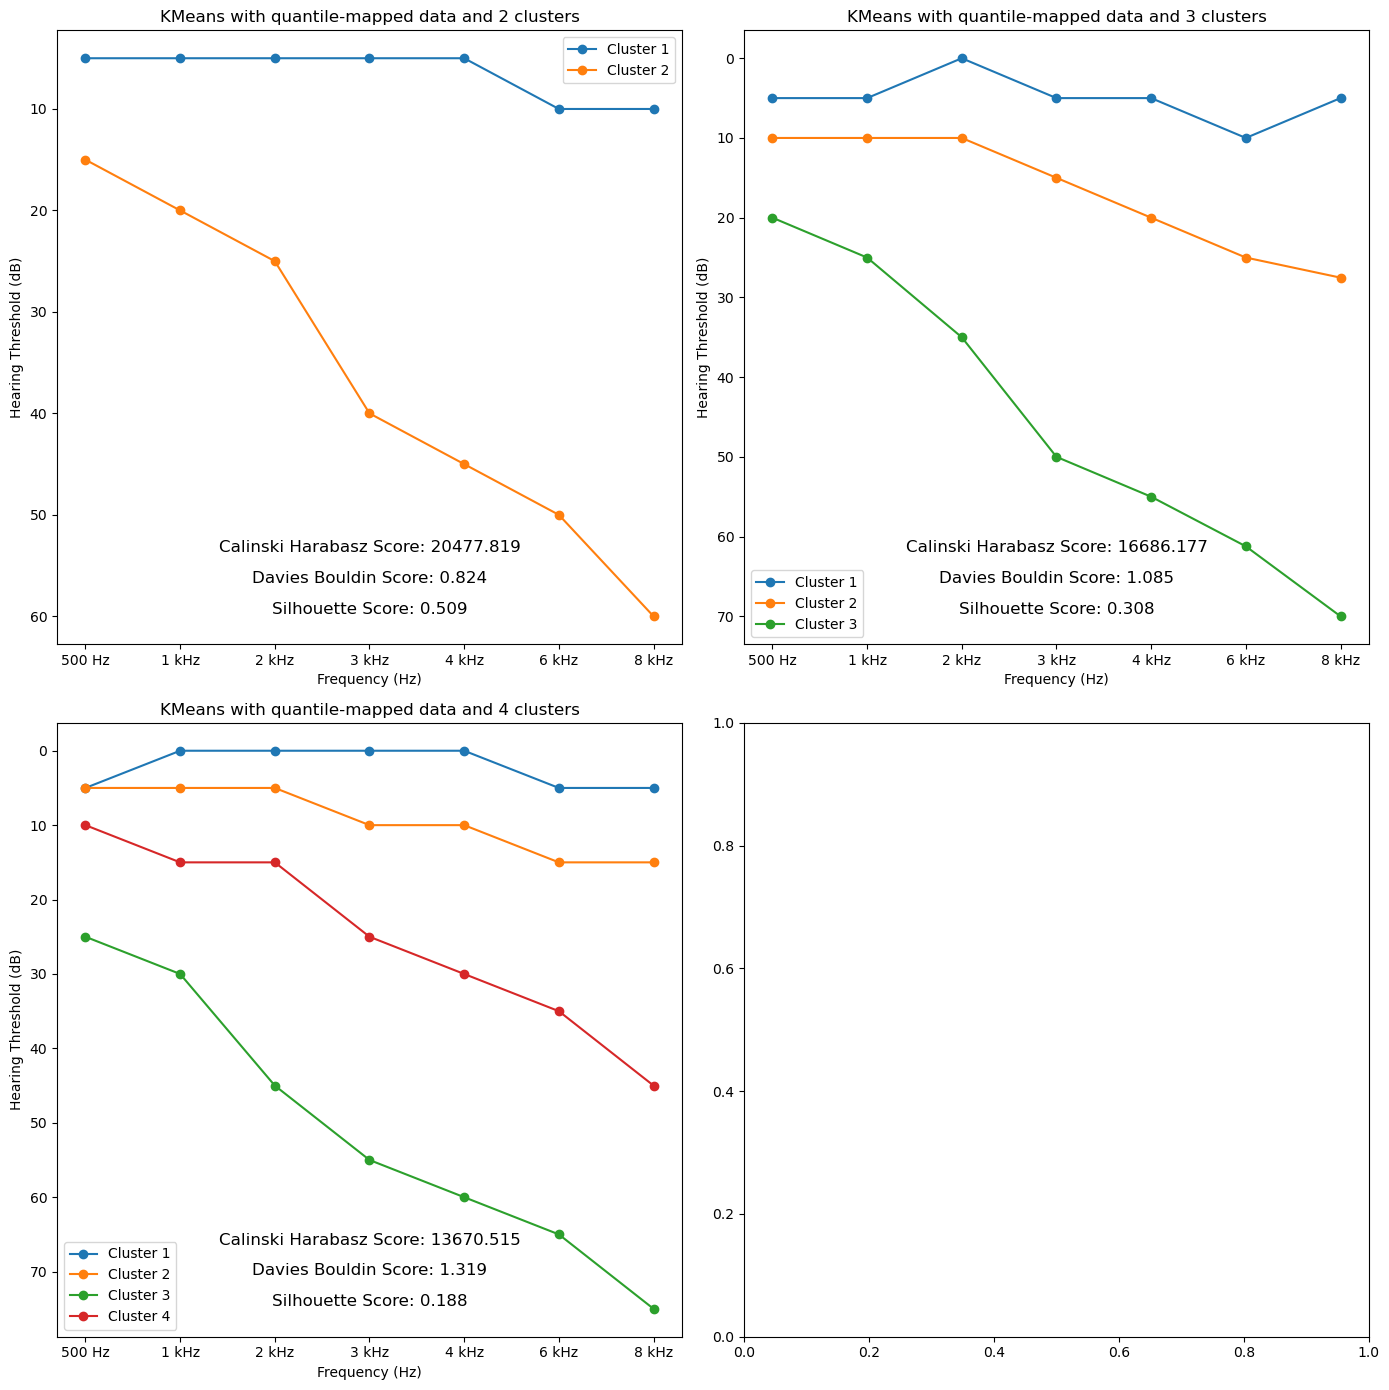

In [17]:
# K-Means with quantile standardized data

# Fit the K-Means algorithm with n clusters = 2, 3, 4

fig, ax = plt.subplots(2, 2, figsize=(14, 14))

for i in range(2, 5):
    # Initialize the KMeans object
    kmeans = KMeans(n_clusters=i, random_state=42, n_init='auto')
    kmeans.fit(quantile_transformed_data, sample_weight = age_weights)

    # Extract the centroids
    centroids = quantile_transformer.inverse_transform(kmeans.cluster_centers_)
    centroids_df = pd.DataFrame(centroids, columns=cleaned_ear_data.columns)

    # Plot the line plot
    row = (i - 2) // 2
    col = (i - 2) % 2
    for cluster_id in range(i):
        ax[row, col].plot(
            centroids_df.columns, 
            centroids_df.iloc[cluster_id], 
            marker='o', 
            label=f'Cluster {cluster_id + 1}'
        )
    ax[row, col].set_title(f'KMeans with quantile-mapped data and {i} clusters')
    ax[row, col].set_xlabel('Frequency (Hz)')
    ax[row, col].set_ylabel('Hearing Threshold (dB)')
    ax[row, col].invert_yaxis()
    ax[row, col].legend()

    # Annotate the Silhouette, Davies Bouldin, and Calinski Harabasz scores
    silhouette = silhouette_score(cleaned_ear_data, kmeans.labels_)
    davies_bouldin = davies_bouldin_score(cleaned_ear_data, kmeans.labels_)
    calinski_harabasz = calinski_harabasz_score(cleaned_ear_data, kmeans.labels_)

    ax[row, col].annotate(f'Silhouette Score: {silhouette:.3f}', 
                          xy=(0.5, 0.05), xycoords='axes fraction', ha='center', fontsize=12)
    ax[row, col].annotate(f'Davies Bouldin Score: {davies_bouldin:.3f}',
                            xy=(0.5, 0.10), xycoords='axes fraction', ha='center', fontsize=12)
    ax[row, col].annotate(f'Calinski Harabasz Score: {calinski_harabasz:.3f}',
                            xy=(0.5, 0.15), xycoords='axes fraction', ha='center', fontsize=12)
    
    # Print out the Silhouette, Davies Bouldin, and Calinski Harabasz scores
    print(f'KMeans with {i} clusters')
    print(f'Silhouette Score: {silhouette:.3f}')
    print(f'Davies Bouldin Score: {davies_bouldin:.3f}')
    print(f'Calinski Harabasz Score: {calinski_harabasz:.3f}')
    print('-' * 50)

plt.tight_layout()
plt.show()

In [18]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Define standardization methods and corresponding data
standardization_methods = {
    "Raw Data": cleaned_ear_data,
    "Z-Score": standard_scaled_data,
    "Min-Max": minmax_scaled_data,
    "Robust": robust_scaled_data,
    "Quantile": quantile_transformed_data
}

# Initialize a dictionary to store results
results = []

for method, data in standardization_methods.items():
    for n_clusters in range(2, 5):
        # Initialize and fit the KMeans object
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
        kmeans.fit(data, sample_weight=age_weights)

        # Calculate clustering scores
        silhouette = silhouette_score(cleaned_ear_data, kmeans.labels_)
        davies_bouldin = davies_bouldin_score(cleaned_ear_data, kmeans.labels_)
        calinski_harabasz = calinski_harabasz_score(cleaned_ear_data, kmeans.labels_)

        # Append the results to the list
        results.append({
            "Method": method,
            "Number of Clusters": n_clusters,
            "Silhouette Score": round(silhouette, 3),
            "Davies-Bouldin Score": round(davies_bouldin, 3),
            "Calinski-Harabasz Score": round(calinski_harabasz, 3)
        })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Pivot the table for better visualization
pivoted_table = results_df.pivot_table(
    index=["Method"], 
    columns=["Number of Clusters"], 
    values=["Silhouette Score", "Davies-Bouldin Score", "Calinski-Harabasz Score"]
)

# Display the table
print(pivoted_table)

                   Calinski-Harabasz Score                        \
Number of Clusters                       2          3          4   
Method                                                             
Min-Max                          24786.249  19919.134  16849.882   
Quantile                         20477.819  16686.177  13670.515   
Raw Data                         24777.968  20002.563  16862.402   
Robust                           19214.541  15992.993  12991.417   
Z-Score                          22675.103  17854.962  14913.140   

                   Davies-Bouldin Score               Silhouette Score         \
Number of Clusters                    2      3      4                2      3   
Method                                                                          
Min-Max                           0.677  0.961  1.137            0.595  0.466   
Quantile                          0.824  1.085  1.319            0.509  0.308   
Raw Data                          0.676  0.961  1.

In [19]:
results_df

,Method,Number of Clusters,Silhouette Score,Davies-Bouldin Score,Calinski-Harabasz Score
0,Raw Data,2,0.595,0.676,24777.968
1,Raw Data,3,0.464,0.961,20002.563
2,Raw Data,4,0.362,1.141,16862.402
3,Z-Score,2,0.588,0.676,22675.103
4,Z-Score,3,0.485,1.006,17854.962
5,Z-Score,4,0.389,1.220,14913.140
6,Min-Max,2,0.595,0.677,24786.249
7,Min-Max,3,0.466,0.961,19919.134
8,Min-Max,4,0.362,1.137,16849.882
9,Robust,2,0.573,0.689,19214.541
